In [1]:
from scipy.sparse.linalg import LinearOperator, eigsh, eigs
from torch.nn.utils import parameters_to_vector
from torch.utils.data import Dataset, DataLoader
import torch
from torch import Tensor
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_hvp(network: nn.Module, loss_fn: nn.Module,
                Y, vector: Tensor):
    """Compute a Hessian-vector product."""
    param_with_grad = [p for p in network.parameters() if p.requires_grad]
    p = len(parameters_to_vector(param_with_grad))
    hvp = torch.zeros(p, dtype=torch.float)
    vector = vector

    loss = loss_fn(Y, network).float()
    grads = torch.autograd.grad(loss, inputs=param_with_grad, create_graph=True)
    dot = parameters_to_vector(grads).mul(vector).sum()
    grads = [g.contiguous() for g in torch.autograd.grad(dot, param_with_grad, retain_graph=True)]
    hvp += parameters_to_vector(grads)
    return hvp

In [3]:
def lanczos(matrix_vector, dim: int, neigs: int, which="LM"):
    """ Invoke the Lanczos algorithm to compute the leading eigenvalues and eigenvectors of a matrix / linear operator
    (which we can access via matrix-vector products). """

    def mv(vec: np.ndarray):
        gpu_vec = torch.tensor(vec, dtype=torch.float)
        return matrix_vector(gpu_vec)

    operator = LinearOperator((dim, dim), matvec=mv)
    l_evals, l_evecs = eigsh(operator, neigs, which=which)
    #s_evals, s_evecs= eigsh(operator, neigs, which='SM')
    return torch.from_numpy(np.ascontiguousarray(l_evals[::-1]).copy()).float(), \
           torch.from_numpy(np.ascontiguousarray(np.flip(l_evecs, -1)).copy()).float()

def get_hessian(network: nn.Module, loss_fn: nn.Module, Y,
                            neigs=6):
    #vector_test = torch.ones(200)
    #print(compute_hvp(network, loss_fn, dataset, vector_test, physical_batch_size=physical_batch_size))
    #sys.exit()
    """ Compute the leading Hessian eigenvalues. """
    hvp_delta = lambda delta: compute_hvp(network, loss_fn, Y, delta)
    param_with_grad = [p for p in network.parameters() if p.requires_grad]
    #nparams = len(parameters_to_vector((network.parameters())))
    nparams = len(parameters_to_vector(param_with_grad))
    #l_evals, l_evecs = lanczos(hvp_delta, nparams, neigs=neigs)

    I = torch.eye(neigs)
    H_recovered = np.column_stack([hvp_delta(I[:, i]) for i in range(neigs)])
    return H_recovered
    

def get_hessian_eigenvalues(network: nn.Module, loss_fn: nn.Module, Y,
                            neigs=6, return_index=None):
    #vector_test = torch.ones(200)
    #print(compute_hvp(network, loss_fn, dataset, vector_test, physical_batch_size=physical_batch_size))
    #sys.exit()
    """ Compute the leading Hessian eigenvalues. """
    hvp_delta = lambda delta: compute_hvp(network, loss_fn, Y, delta)
    param_with_grad = [p for p in network.parameters() if p.requires_grad]
    #nparams = len(parameters_to_vector((network.parameters())))
    nparams = len(parameters_to_vector(param_with_grad))
    #l_evals, l_evecs = lanczos(hvp_delta, nparams, neigs=neigs)

    I = torch.eye(neigs)
    H_recovered = np.column_stack([hvp_delta(I[:, i]) for i in range(neigs)])
    hess_eigs, eig_vec = np.linalg.eig(H_recovered)
    print(hess_eigs)
    sorted_indices = np.argsort(hess_eigs)
    index_of_second_smallest = sorted_indices[return_index]
    return hess_eigs[index_of_second_smallest], eig_vec[:, index_of_second_smallest]
    #return l_evals, l_evecs

In [4]:
def gradient_norm(Y, network, loss_fn):
    param_with_grad = [p for p in network.parameters() if p.requires_grad]
    p = len(parameters_to_vector(param_with_grad))
    loss = loss_fn(Y, network).float()
    grads = torch.autograd.grad(loss, inputs=param_with_grad, create_graph=True)
    return parameters_to_vector(grads).norm()

In [5]:
def loss_fn(Y, model):
    return 0.5 * torch.norm(Y - model())**2

In [6]:
class LoRALinear(nn.Module):
    def __init__(self, B_init, A_init):
        super().__init__()
        self.B = nn.Parameter(data = B_init.data, requires_grad=True)
        self.A = nn.Parameter(data = A_init.data, requires_grad=True)
        #self.B = nn.Parameter(data = torch.Tensor([[1], [-1]]) + epsilon * torch.randn((2,1)), requires_grad=True)
        #self.A = nn.Parameter(data = torch.Tensor([[1], [-1]]) + epsilon * torch.randn((2,1)), requires_grad=True)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.5)

    def forward(self):
        result = self.leaky_relu(self.B @ self.A.T)
        return result

[-0.87863123 -0.15551913  1.1741413   0.5604395 ]
[ 1.1734316  -0.8633979   0.37486508  0.01553168]
[ 1.1740849  -0.85345817  0.28596124  0.09384259]
[ 1.1761334  -0.8466107   0.43334907 -0.0624412 ]
[ 1.1803968   0.6160163  -0.8417697  -0.25421298]
[ 1.1896443   0.7995256  -0.8385052  -0.45023423]
[-0.83754474 -0.64622915  1.214806    0.96939844]
[ 1.2962857   1.0841981  -0.81060076 -0.8694526 ]
[ 1.4527655   1.1247907  -1.0518439  -0.82528186]


Text(0.5, 0, '$\\alpha$')

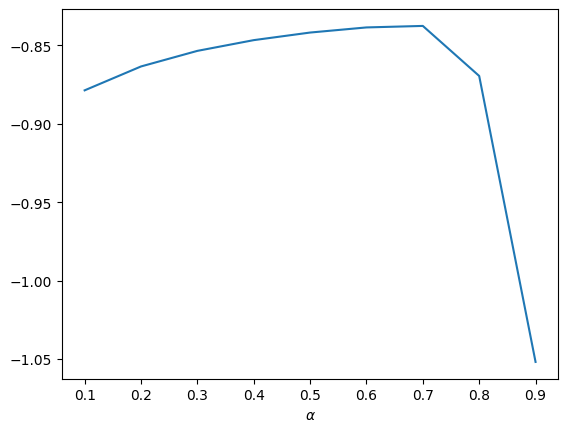

In [13]:
B_init, A_init = torch.randn(2,1), torch.randn(2,1)
model = LoRALinear(B_init=B_init, A_init=A_init)
eig_a = []
for a in np.arange(0.1,1,0.1):
    Y = torch.Tensor([
        [1-a, -0.5 - 2*a],
        [-0.5-2*a, 1-a]
    ])
    min_eig = np.min(get_hessian_eigenvalues(model, loss_fn, Y, 4))
    eig_a.append(min_eig)

plt.plot(np.arange(0.1,1,0.1), eig_a)
plt.xlabel(r"$\alpha$")

In [14]:
from torch.optim import SGD

a = 0.1
B_init, A_init = torch.randn(2,1), torch.randn(2,1)
model = LoRALinear(B_init=B_init, A_init=A_init)
optimizer = SGD(model.parameters(), lr=0.1)
Y = torch.Tensor([
        [1-a, -0.5 - 2*a],
        [-0.5-2*a, 1-a]
    ])
for step in range(200):
    loss = loss_fn(Y, model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



In [34]:
B_init = torch.Tensor([[1], [-1]])
A_init = torch.Tensor([[1], [-1]])

model.B.data = B_init
model.A.data = A_init

print(loss_fn(Y, model))

tensor(0.0500, grad_fn=<MulBackward0>)


In [25]:
print(loss_fn(Y, model))

tensor(0.0500, grad_fn=<MulBackward0>)


In [27]:
model.leaky_relu(model.B @ model.A.T) - Y

tensor([[0.1008, 0.2046],
        [0.1954, 0.0992]], grad_fn=<SubBackward0>)

In [28]:
torch.norm(model.leaky_relu(model.B @ model.A.T) - Y)**2

tensor(0.1000, grad_fn=<PowBackward0>)

In [17]:
model.A

Parameter containing:
tensor([[-1.4158],
        [ 1.4018]], requires_grad=True)

In [28]:
gradient_norm(Y, model, loss_fn)

tensor(0., grad_fn=<LinalgVectorNormBackward0>)

In [6]:
class LoRALinearP(nn.Module):
    def __init__(self):
        super().__init__()
        self.B = nn.Parameter(data = 1.005 * torch.Tensor([[1], [-1]]), requires_grad=True)
        self.A = nn.Parameter(data = 0.995 * torch.Tensor([[1], [-1]]), requires_grad=True)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.5)

    def forward(self):
        result = self.leaky_relu(self.B @ self.A.T)
        return result

In [9]:
model = LoRALinearP()
eig_a = []
a = 0.1
Y = torch.Tensor([
    [1-a, -0.5 - 2*a],
    [-0.5-2*a, 1-a]
])
min_eig = np.min(get_hessian_eigenvalues(model, loss_fn, Y, 4))

[3.1136864e-05 2.9998645e-01 2.5000312e+00 2.2000761e+00]


In [26]:
model()

tensor([[ 1.0000, -0.5000],
        [-0.5000,  1.0000]], grad_fn=<LeakyReluBackward0>)

In [ ]:
- (Y - model)

In [7]:
class LoRATanh(nn.Module):
    def __init__(self, B_init, A_init):
        super().__init__()
        self.B = nn.Parameter(data = B_init.clone(), requires_grad=True)
        self.A = nn.Parameter(data = A_init.clone(), requires_grad=True)
        self.tanh = nn.Tanh()

    def forward(self):
        result = self.tanh(self.B @ self.A.T)
        return result

In [7]:
B_init, A_init = torch.Tensor([[1], [-1]]),  torch.Tensor([[1], [-1]])
a = 0.1
loratanh = LoRATanh(B_init, A_init)

loss_fn(Y, loratanh)

NameError: name 'Y' is not defined

In [10]:
from torch.optim import SGD

a = 0.1
B_init, A_init =  torch.Tensor([[1], [-1]]),  torch.Tensor([[1], [-1]])
model = LoRATanh(B_init=B_init, A_init=A_init)
Y = model().detach() - a * torch.ones((2,2)) / (1 - model().detach()**2)

B_init, A_init = 0.1* torch.randn(2,1), 0.1*torch.randn(2,1)
model = LoRATanh(B_init=B_init, A_init=A_init)
optimizer = SGD(model.parameters(), lr=0.1)

for step in range(200):
    loss = loss_fn(Y, model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step%20==0:
        print("step: ", step)
        print("loss: ", loss_fn(Y, model))
        min_eig = np.min(get_hessian_eigenvalues(model, loss_fn, Y, 4))
        print("min eig: ", min_eig)

step:  0
loss:  tensor(1.2602, grad_fn=<MulBackward0>)
[ 1.5727413  -1.4833928   0.439985   -0.35051012]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [53]:
Y

tensor([[-0.0759,  0.0982],
        [-0.0897, -0.0134]])

In [50]:
Y - model()

tensor([[ 0.0019,  0.0302],
        [-0.0054, -0.0980]], grad_fn=<SubBackward0>)

In [49]:
print(model.B, model.A)

Parameter containing:
tensor([[-0.7607],
        [-0.2449]], requires_grad=True) Parameter containing:
tensor([[0.3514],
        [0.0325]], requires_grad=True)


In [43]:
from torch.optim import SGD

a = 0.1
B_init, A_init = torch.Tensor([[1], [-1]]),  torch.Tensor([[1], [-1]])
model = LoRATanh(B_init=B_init, A_init=A_init)
Y = model().detach() - a * torch.ones((2,2)) / (1 - model().detach()**2)
print(gradient_norm(Y, model, loss_fn))
optimizer = SGD(model.parameters(), lr=0.01)
for step in range(200):
    loss = loss_fn(Y, model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step%20==0:
        print("step: ", step)
        print("loss: ", loss_fn(Y, model))
        min_eig = np.min(get_hessian_eigenvalues(model, loss_fn, Y, 4))
        print("min eig: ", min_eig)

tensor(0., grad_fn=<LinalgVectorNormBackward0>)
step:  0
loss:  tensor(0.1134, grad_fn=<MulBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
min eig:  7.450581e-09
step:  20
loss:  tensor(0.1134, grad_fn=<MulBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
min eig:  7.450581e-09
step:  40
loss:  tensor(0.1134, grad_fn=<MulBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
min eig:  7.450581e-09
step:  60
loss:  tensor(0.1134, grad_fn=<MulBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
min eig:  7.450581e-09
step:  80
loss:  tensor(0.1134, grad_fn=<MulBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
min eig:  7.450581e-09
step:  100
loss:  tensor(0.1134, grad_fn=<MulBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
min eig:  7.450581e-09
step:  120
loss:  tensor(0.1134, grad_fn=<MulBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
min eig:  7.450

In [54]:
loratanh = LoRATanh()
a = 0.1
Y = loratanh().detach() - a * torch.ones((2,2)) / (1 - loratanh().detach()**2)

tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
tensor(8.9407e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 7.0551360e-01  5.6203210e-01 -4.4703484e-08  1.4348142e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[7.0551342e-01 6.6666967e-01 1.2104868e-16 3.8843751e-02]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[-6.5793812e-02 -1.0408341e-17  7.7130747e-01  7.0551366e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 8.759451e-01  7.055136e-01 -1.704315e-01 -6.500443e-17]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 9.8058283e-01  7.0551360e-01 -2.7506924e-01 -1.2734542e-16]
tensor(1.1921e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 1.0852205e+00  7.0551378e-01 -3.7970668e-01  5.9604645e-08]
tensor(1.1921e-07, grad_fn=<LinalgVectorNormBackward0>)
[-4.8434454e-01 -5.9604645e-08  1.1898580e+00  7.0551354e-01]
tensor(2.3842e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 1.2944957e+00  7.0551360e-01 -5.8898222e-01 -1.192

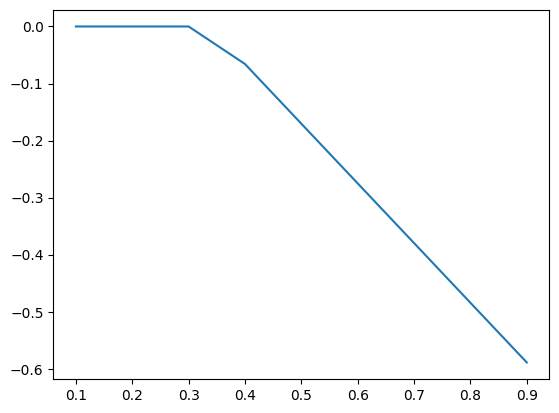

In [9]:
eig_a = []
eig_vecs = []
hessian_a = []
B_init, A_init = torch.Tensor([[1], [-1]]),  torch.Tensor([[1], [-1]])
loratanh = LoRATanh(B_init=B_init, A_init=A_init)
for a in np.arange(0.1,1,0.1):
    Y = loratanh().detach() - a * torch.ones((2,2)) / (1 - loratanh().detach()**2)
    print(gradient_norm(Y, loratanh, loss_fn))
    if a <= 0.31:
        return_index = 0
    else:
        return_index = 0
    hessian = get_hessian(loratanh, loss_fn, Y, 4)
    min_eig, eig_vec = get_hessian_eigenvalues(loratanh, loss_fn, Y, 4, return_index=return_index)
    eig_a.append(min_eig)
    eig_vecs.append(eig_vec)
    hessian_a.append(hessian)

plt.plot(np.arange(0.1,1,0.1), eig_a)

tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
tensor(8.9407e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 7.0551360e-01  5.6203210e-01 -4.4703484e-08  1.4348142e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[7.0551342e-01 6.6666967e-01 1.2104868e-16 3.8843751e-02]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[-6.5793812e-02 -1.0408341e-17  7.7130747e-01  7.0551366e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 8.759451e-01  7.055136e-01 -1.704315e-01 -6.500443e-17]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 9.8058283e-01  7.0551360e-01 -2.7506924e-01 -1.2734542e-16]
tensor(1.1921e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 1.0852205e+00  7.0551378e-01 -3.7970668e-01  5.9604645e-08]
tensor(1.1921e-07, grad_fn=<LinalgVectorNormBackward0>)
[-4.8434454e-01 -5.9604645e-08  1.1898580e+00  7.0551354e-01]
tensor(2.3842e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 1.2944957e+00  7.0551360e-01 -5.8898222e-01 -1.192

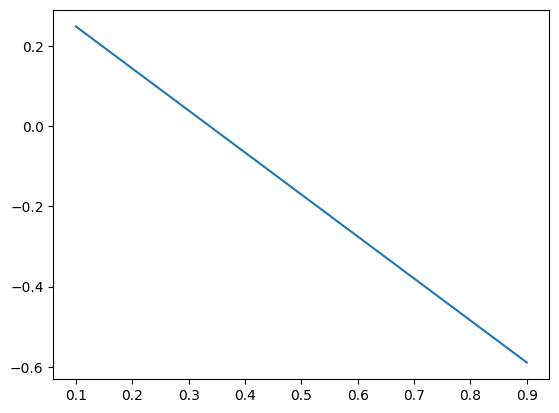

In [33]:
eig_a = []
eig_vecs = []
hessian_a = []
B_init, A_init = torch.Tensor([[1], [-1]]),  torch.Tensor([[1], [-1]])
loratanh = LoRATanh(B_init=B_init, A_init=A_init)
for a in np.arange(0.1,1,0.1):
    Y = loratanh().detach() - a * torch.ones((2,2)) / (1 - loratanh().detach()**2)
    print(gradient_norm(Y, loratanh, loss_fn))
    if a <= 0.31:
        return_index = 1
    else:
        return_index = 0
    hessian = get_hessian(loratanh, loss_fn, Y, 4)
    min_eig, eig_vec = get_hessian_eigenvalues(loratanh, loss_fn, Y, 4, return_index=return_index)
    eig_a.append(min_eig)
    eig_vecs.append(eig_vec)
    hessian_a.append(hessian)

plt.plot(np.arange(0.1,1,0.1), eig_a)

In [76]:
eig_a

[0.24811913,
 0.14348142,
 1.2104868e-16,
 -0.06579381,
 -0.1704315,
 -0.27506924,
 -0.37970668,
 -0.48434454,
 -0.5889822]

In [86]:
hessian_a[2] - hessian_a[0]

array([[-1.1920929e-07,  0.0000000e+00, -1.0463769e-01, -1.0463758e-01],
       [ 0.0000000e+00, -1.1920929e-07, -1.0463758e-01, -1.0463769e-01],
       [-1.0463769e-01, -1.0463758e-01, -1.1920929e-07,  0.0000000e+00],
       [-1.0463758e-01, -1.0463769e-01,  0.0000000e+00, -1.1920929e-07]],
      dtype=float32)

In [19]:
def cosine_similarity(a, b):
    return a @ b / np.linalg.norm(a) / np.linalg.norm(b)

for i in range(len(eig_a)):
    print(cosine_similarity(eig_vecs[0], eig_vecs[i]))

1.0
0.96564466
-0.93928623
-0.92402333
-0.9142238
0.9073916
0.9023426
0.8984507
0.8953539
-0.89282805


In [10]:
a = 0.1
J = torch.cat([torch.kron(loratanh.A, torch.eye(2)), torch.kron(torch.eye(2), loratanh.B)], axis=-1)
x1 = torch.Tensor([[1],[0]])
x2 = torch.Tensor([[0],[1]])
tanh_derivative = 1 - loratanh()**2
tanh_second_der = -2*loratanh()*tanh_derivative
grad_s = a * torch.ones((2,2))/ tanh_derivative
Delta_Hw = torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0])) + torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

In [11]:
G_outer = torch.zeros(4, 4)
G_outer[:2, 2:] =  a * torch.Tensor([[1, 1], [1, 1]])
G_outer[2:, :2] =  a * torch.Tensor([[1, 1], [1, 1]]).T
H_matrix = G_outer + J.T @ Delta_Hw @ J
print(eigs(H_matrix.detach()))

/tmp/ipykernel_325613/3867451448.py:5: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs(H_matrix.detach()))


(array([ 1.04637675e-01+0.j, -1.04637668e-01+0.j,  0.00000000e+00+0.j,
        5.09438447e-09+0.j], dtype=complex64), array([[ 4.9999994e-01,  5.0000000e-01,  1.9544721e-08, -7.0710683e-01],
       [ 5.0000006e-01,  5.0000006e-01,  2.8248412e-08,  7.0710665e-01],
       [-5.0000006e-01,  5.0000000e-01, -7.0710677e-01, -1.7875745e-07],
       [-5.0000006e-01,  5.0000000e-01,  7.0710677e-01,  2.7936133e-07]],
      dtype=float32))


In [10]:
torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0]))

tensor([[-0.1523,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.1523,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<UnsafeViewBackward0>)

In [11]:
Delta_Hw

tensor([[-0.1523,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.1523,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1523,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1523]], grad_fn=<AddBackward0>)

In [13]:
J

tensor([[ 1.,  0.,  1.,  0.],
        [ 0.,  1., -1., -0.],
        [-1., -0.,  0.,  1.],
        [-0., -1., -0., -1.]], grad_fn=<CatBackward0>)

In [12]:
J.T @ Delta_Hw @ J

tensor([[ 0.0000,  0.0000, -0.1523, -0.1523],
        [ 0.0000,  0.0000, -0.1523, -0.1523],
        [-0.1523, -0.1523,  0.0000,  0.0000],
        [-0.1523, -0.1523,  0.0000,  0.0000]], grad_fn=<MmBackward0>)

In [12]:
G_outer

tensor([[0.0000, 0.0000, 0.1000, 0.1000],
        [0.0000, 0.0000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.0000, 0.0000]])

In [19]:
eig_vec = torch.Tensor(eig_vecs[0])
eig_vec.T @ (J.T @ Delta_Hw @ J) @ eig_vec

/tmp/ipykernel_3357544/1386701268.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  eig_vec.T @ (J.T @ Delta_Hw @ J) @ eig_vec


tensor(-0.3046, grad_fn=<DotBackward0>)

In [17]:
eig_vecs

[array([-0.5, -0.5, -0.5, -0.5], dtype=float32),
 array([0.5, 0.5, 0.5, 0.5], dtype=float32),
 array([0.5, 0.5, 0.5, 0.5], dtype=float32),
 array([-0.5, -0.5, -0.5, -0.5], dtype=float32),
 array([0.5, 0.5, 0.5, 0.5], dtype=float32),
 array([0.5, 0.5, 0.5, 0.5], dtype=float32),
 array([0.5, 0.5, 0.5, 0.5], dtype=float32),
 array([0.5, 0.5, 0.5, 0.5], dtype=float32),
 array([0.5, 0.5, 0.5, 0.5], dtype=float32)]

tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]
tensor(8.9407e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 7.0551360e-01  5.6203210e-01 -4.4703484e-08  1.4348142e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[7.0551342e-01 6.6666967e-01 1.2104868e-16 3.8843751e-02]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[-6.5793812e-02 -1.0408341e-17  7.7130747e-01  7.0551366e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 8.759451e-01  7.055136e-01 -1.704315e-01 -6.500443e-17]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 9.8058283e-01  7.0551360e-01 -2.7506924e-01 -1.2734542e-16]
tensor(1.1921e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 1.0852205e+00  7.0551378e-01 -3.7970668e-01  5.9604645e-08]
tensor(1.1921e-07, grad_fn=<LinalgVectorNormBackward0>)
[-4.8434454e-01 -5.9604645e-08  1.1898580e+00  7.0551354e-01]
tensor(2.3842e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 1.2944957e+00  7.0551360e-01 -5.8898222e-01 -1.192

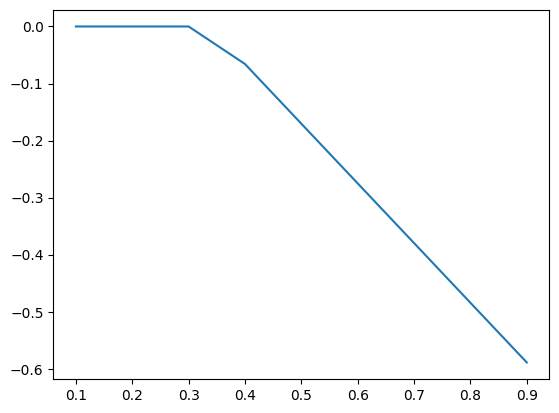

In [22]:
eig_a = []
for a in np.arange(0.1,1,0.1):
    Y = loratanh().detach() - a * torch.ones((2,2)) / (1 - loratanh().detach()**2)
    print(gradient_norm(Y, loratanh, loss_fn))
    min_eig = np.min(get_hessian_eigenvalues(loratanh, loss_fn, Y, 4))
    eig_a.append(min_eig)

plt.plot(np.arange(0.1,1,0.1), eig_a)

In [56]:
get_hessian_eigenvalues(loratanh, loss_fn, Y, 4)

[7.4505806e-09 7.0551366e-01 2.4811913e-01 4.5739451e-01]


array([7.4505806e-09, 7.0551366e-01, 2.4811913e-01, 4.5739451e-01],
      dtype=float32)

In [57]:
gradient_norm(Y, loratanh, loss_fn)

tensor(0., grad_fn=<LinalgVectorNormBackward0>)

tensor(2.6342e-09, grad_fn=<LinalgVectorNormBackward0>)
[5.3689510e-01 2.1508646e-01 2.1287370e-09 3.4475173e-03]
tensor(1.0537e-08, grad_fn=<LinalgVectorNormBackward0>)
[-9.4790988e-02  4.2574744e-09  3.0563736e-01  5.4458261e-01]
tensor(1.0537e-08, grad_fn=<LinalgVectorNormBackward0>)
[-2.1222882e-01  2.1287374e-09  3.9831084e-01  5.6934702e-01]
tensor(7.3000e-08, grad_fn=<LinalgVectorNormBackward0>)
[-3.3433419e-01 -8.5149479e-09  6.3318694e-01  4.5657629e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[-4.5828065e-01  4.6796876e-17  7.3405164e-01  4.7965810e-01]
tensor(5.5755e-08, grad_fn=<LinalgVectorNormBackward0>)
[-5.8315903e-01 -5.0719062e-17  8.4976345e-01  4.8882452e-01]
tensor(4.2147e-08, grad_fn=<LinalgVectorNormBackward0>)
[-7.0858169e-01 -1.4229931e-16  9.7075909e-01  4.9325177e-01]
tensor(8.4294e-08, grad_fn=<LinalgVectorNormBackward0>)
[-8.3435291e-01  1.0940454e+00  1.4520287e-16  4.9573669e-01]
tensor(4.2147e-08, grad_fn=<LinalgVectorNormBackward0>)
[-9.6036184e

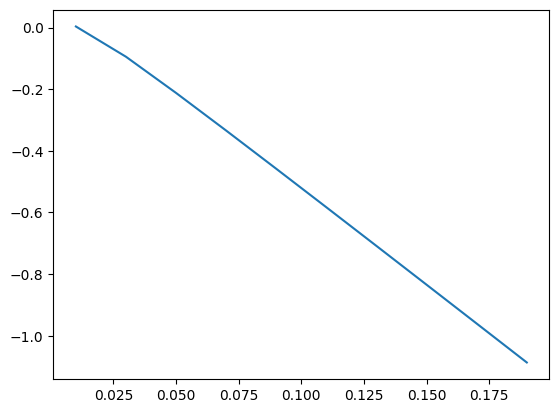

In [32]:
eig_a = []
eig_vecs = []
hessian_a = []
B_init, A_init = torch.Tensor([[2], [-1]]),  torch.Tensor([[1], [-1]])
loratanh = LoRATanh(B_init=B_init, A_init=A_init)
for a in np.arange(0.01,0.2,0.02):
    Y = loratanh().detach() - a * torch.Tensor([[1, 1], [2, 2]]) / (1 - loratanh().detach()**2)
    print(gradient_norm(Y, loratanh, loss_fn))
    if a <= 0.011:
        return_index = 1
    else:
        return_index = 0
    hessian = get_hessian(loratanh, loss_fn, Y, 4)
    min_eig, eig_vec = get_hessian_eigenvalues(loratanh, loss_fn, Y, 4, return_index=return_index)
    eig_a.append(min_eig)
    eig_vecs.append(eig_vec)
    hessian_a.append(hessian)

plt.plot(np.arange(0.01,0.2,0.02), eig_a)

In [23]:
for i in range(len(eig_a)):
    print(cosine_similarity(eig_vecs[1], eig_vecs[i]))

0.96564466
1.0
-0.9961081
-0.9913832
-0.98766303
0.98478466
0.9825132
0.98068
0.9791704
-0.97790563


In [33]:
a = 0.01
J = torch.cat([torch.kron(loratanh.A, torch.eye(2)), torch.kron(torch.eye(2), loratanh.B)], axis=-1)
x1 = torch.Tensor([[1],[0]])
x2 = torch.Tensor([[0],[1]])
tanh_derivative = 1 - loratanh()**2
tanh_second_der = -2*loratanh()*tanh_derivative
grad_s = a * torch.Tensor([[1, 1], [2, 2]])/ tanh_derivative
Delta_Hw = torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0])) + torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

In [42]:
torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0]))

tensor([[-0.0193,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0305,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<UnsafeViewBackward0>)

In [44]:
torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0193,  0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0305]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
eigs

In [34]:
J_eigvals, J_eigvecs = eigs((J.T @ Delta_Hw @ J).detach())
print(J_eigvals, J_eigvecs)
J_eigvec = J_eigvecs[:, 1]

[ 8.3707884e-02+0.j -8.3707884e-02+0.j -1.9217028e-09+0.j
 -7.3063189e-10+0.j] [[ 0.4606628   0.4606628  -0.21106668 -0.16452709]
 [ 0.3639294   0.36392942  0.8286513  -0.6213741 ]
 [-0.22130191  0.77869797 -0.36659774  0.5416757 ]
 [-0.77869797  0.221302    0.36659774 -0.5416757 ]]


/tmp/ipykernel_2370316/785390047.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  J_eigvals, J_eigvecs = eigs((J.T @ Delta_Hw @ J).detach())


In [21]:
cosine_similarity(J_eigvec, eig_vec.numpy())

0.88605565

In [26]:
print(J_eigvec.T @ (J.T @ Delta_Hw @ J).detach().numpy() @ J_eigvec)
print(J_eigvec.T @ G_outer.numpy() @ J_eigvec)

-0.08370787
0.023770433


In [15]:
eig_vec = torch.Tensor(eig_vecs[0])
eig_vec.T @ (J.T @ Delta_Hw @ J) @ eig_vec

/tmp/ipykernel_2370316/1386701268.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  eig_vec.T @ (J.T @ Delta_Hw @ J) @ eig_vec


tensor(-0.0483, grad_fn=<DotBackward0>)

In [13]:
G_outer = torch.zeros(4, 4)
G_outer[:2, 2:] =  a * torch.Tensor([[1, 1], [2, 2]])
G_outer[2:, :2] =  a * torch.Tensor([[1, 1], [2, 2]]).T

In [14]:
eigs(G_outer)

/tmp/ipykernel_2370316/2106593903.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs(G_outer)


(array([-3.1622771e-02+0.j,  3.1622771e-02+0.j,  0.0000000e+00+0.j,
        -4.0727705e-10+0.j], dtype=complex64),
 array([[ 3.1622779e-01, -3.1622788e-01,  1.6618843e-07, -8.9442718e-01],
        [ 6.3245559e-01, -6.3245559e-01, -9.1077254e-08,  4.4721365e-01],
        [-4.9999997e-01, -4.9999994e-01, -7.0710677e-01,  4.2159058e-09],
        [-4.9999994e-01, -5.0000000e-01,  7.0710677e-01,  2.3063606e-08]],
       dtype=float32))

In [15]:
10**0.5

3.1622776601683795

In [14]:
eigs(G_outer.detach())

/tmp/ipykernel_3508707/1870175823.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs(G_outer.detach())


(array([-3.1622773e-01+0.j,  3.1622782e-01+0.j,  1.1102230e-16+0.j,
        -3.5304244e-09+0.j], dtype=complex64),
 array([[ 3.16227734e-01, -3.16227794e-01,  1.04767174e-07,
         -8.94427180e-01],
        [ 6.32455468e-01, -6.32455587e-01, -1.28738913e-08,
          4.47213590e-01],
        [-5.00000060e-01, -4.99999970e-01, -7.07106769e-01,
          7.79171998e-08],
        [-5.00000000e-01, -5.00000060e-01,  7.07106769e-01,
         -9.29490724e-08]], dtype=float32))

In [16]:
eig_vec.T @ G_outer @ eig_vec

tensor(0.0127)

In [41]:
H_matrix

tensor([[ 0.0000,  0.0000, -0.0286, -0.0286],
        [ 0.0000,  0.0000, -0.0105, -0.0105],
        [-0.0286, -0.0105, -0.0467,  0.0000],
        [-0.0286, -0.0105,  0.0000,  0.0467]], grad_fn=<AddBackward0>)

In [40]:
H_matrix = G_outer + J.T @ Delta_Hw @ J
print(eigs(H_matrix.detach()))

(array([ 6.3462287e-02+0.j, -6.3462295e-02+0.j, -1.8842918e-09+0.j,
        1.2702800e-09+0.j], dtype=complex64), array([[ 0.45004812,  0.4500482 ,  0.0855727 , -0.4626214 ],
       [ 0.16488168,  0.16488159,  0.92597604,  0.878124  ],
       [-0.13239257,  0.8676075 , -0.26004398,  0.08625442],
       [-0.8676076 ,  0.1323925 ,  0.26004404, -0.08625436]],
      dtype=float32))


/tmp/ipykernel_285718/2650765346.py:2: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs(H_matrix.detach()))


In [19]:
eig_a

[0.0034475173,
 -0.09479099,
 -0.21222882,
 -0.3343342,
 -0.45828065,
 -0.583159,
 -0.7085817,
 -0.8343529,
 -0.96036184,
 -1.0865407]

In [47]:
B_init[0].shape

torch.Size([1])

tensor(1.6660e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 1.4574885e+00  7.3436022e-01  4.7723501e-09 -3.3180022e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 2.3364110e+00 -1.1562924e+00  6.8483454e-01  8.5521528e-09]
tensor(3.6500e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 3.2291329e+00 -1.9888834e+00  6.2960798e-01  1.2357290e-08]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 4.1251001e+00 -2.8235204e+00  5.7318223e-01  2.2243158e-08]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 5.0223317e+00 -3.6589770e+00  5.1631182e-01 -2.4332868e-08]
tensor(7.3000e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 5.9201865e+00 -4.4948440e+00  4.5922861e-01 -5.7122929e-10]
tensor(1.1921e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 6.8183928e+00 -5.3309450e+00  4.0202743e-01  2.7554963e-09]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 7.7168188e+00 -6.1671929e+00  3.4475392e-01  5.6266161e-09]
tensor(8.4294e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 8.6153889e+00 -7.0035372e+00  

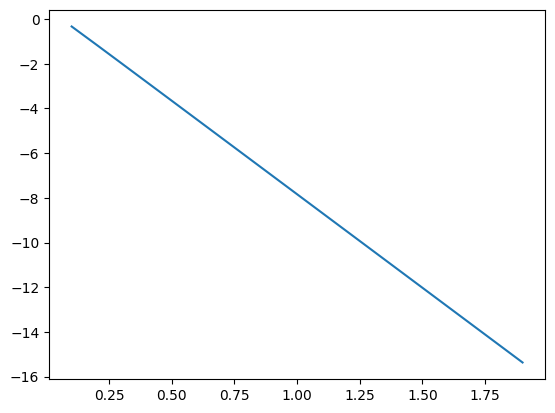

In [8]:
eig_a = []
eig_vecs = []
hessian_a = []
torch.manual_seed(20)
B_init, A_init = torch.rand(2, 1), torch.rand(2, 1)
loratanh = LoRATanh(B_init=B_init, A_init=A_init)
G = torch.Tensor([
    [1, -A_init[0]/A_init[1]],
    [-B_init[0]/B_init[1], B_init[0]*A_init[0]/(B_init[1]*A_init[1])]
])
for a in np.arange(0.1,2.0,0.1):
    Y = loratanh().detach() - a * G / (1 - loratanh().detach()**2)
    print(gradient_norm(Y, loratanh, loss_fn))
    if a <= 0.61:
        return_index = 0
    else:
        return_index = 0
    hessian = get_hessian(loratanh, loss_fn, Y, 4)
    min_eig, eig_vec = get_hessian_eigenvalues(loratanh, loss_fn, Y, 4, return_index=return_index)
    eig_a.append(min_eig)
    eig_vecs.append(eig_vec)
    hessian_a.append(hessian)

plt.plot(np.arange(0.1,2.0,0.1), eig_a)

In [9]:
a = 0.1
J = torch.cat([torch.kron(loratanh.A, torch.eye(2)), torch.kron(torch.eye(2), loratanh.B)], axis=-1)
x1 = torch.Tensor([[1],[0]])
x2 = torch.Tensor([[0],[1]])
tanh_derivative = 1 - loratanh()**2
tanh_second_der = -2*loratanh()*tanh_derivative
grad_s = a * G/ tanh_derivative
Delta_Hw = torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0])) + torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

In [41]:
loratanh.B

Parameter containing:
tensor([[0.5615],
        [0.1774]], requires_grad=True)

In [42]:
loratanh.A

Parameter containing:
tensor([[0.8147],
        [0.3295]], requires_grad=True)

In [24]:
loratanh()

tensor([[0.4280, 0.1829],
        [0.1435, 0.0584]], grad_fn=<TanhBackward0>)

In [23]:
grad_s * tanh_second_der

tensor([[-0.0856,  0.0905],
        [ 0.0909, -0.0914]], grad_fn=<MulBackward0>)

In [10]:
Delta_Hw

tensor([[-0.0856,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0909,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0905,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.0914]], grad_fn=<AddBackward0>)

In [43]:
J

tensor([[0.8147, 0.0000, 0.5615, 0.0000],
        [0.0000, 0.8147, 0.1774, 0.0000],
        [0.3295, 0.0000, 0.0000, 0.5615],
        [0.0000, 0.3295, 0.0000, 0.1774]], grad_fn=<CatBackward0>)

In [11]:
eigs(J.detach())

/tmp/ipykernel_3508707/2508882252.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs(J.detach())


(array([ 1.0313823e+00+0.j,  8.1471372e-01+0.j, -3.9272867e-02+0.j,
         2.1561603e-07+0.j], dtype=complex64),
 array([[ 8.8960344e-01, -6.1629617e-01, -5.2385420e-01,  5.3076804e-01],
        [ 2.8106374e-01,  6.9953102e-01, -1.6550760e-01,  1.6769196e-01],
        [ 3.4328645e-01, -5.8036687e-07,  7.9675412e-01, -7.7014488e-01],
        [ 1.0845886e-01,  3.6171171e-01,  2.5172809e-01, -3.1151500e-01]],
       dtype=float32))

In [61]:
J.T @ Delta_Hw @ J

tensor([[ 0.0411,  0.0000, -0.0220,  0.0466],
        [ 0.0000, -0.0404,  0.0227, -0.0476],
        [-0.0220,  0.0227,  0.0037,  0.0000],
        [ 0.0466, -0.0476,  0.0000, -0.0026]], grad_fn=<MmBackward0>)

In [33]:
torch.norm(eig_vec)

tensor(1.)

In [36]:
eig_vec = torch.Tensor(eig_vecs[0])
eig_vec.T @ (J.T @ Delta_Hw @ J) @ eig_vec

tensor(0.0452, grad_fn=<DotBackward0>)

In [39]:
eig_vec.T @ G_outer @ eig_vec

tensor(-0.8577)

In [44]:
G

tensor([[ 1.0000, -2.4723],
        [-3.1651,  7.8250]])

In [40]:
eigs(G_outer.detach())

/tmp/ipykernel_1692302/1870175823.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs(G_outer.detach())


(array([ 8.8521904e-01+0.j, -8.8521922e-01+0.j, -1.9256134e-09+0.j,
         4.8824020e-09+0.j], dtype=complex64),
 array([[-0.21302576, -0.21302581, -0.5943874 ,  0.92025214],
        [ 0.67425513,  0.67425513, -0.18779221,  0.29074672],
        [-0.26514733,  0.26514724,  0.7248902 ,  0.24280943],
        [ 0.6555128 , -0.6555127 ,  0.2932096 ,  0.09821358]],
       dtype=float32))

In [45]:
eigs((Delta_Hw).detach())

/tmp/ipykernel_1692302/1906482423.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs((Delta_Hw).detach())


(array([-0.08560043+0.j,  0.0908579 +0.j,  0.09045964+0.j, -0.09138556+0.j],
       dtype=complex64),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=float32))

In [16]:
eigs((J.T @ Delta_Hw @ J).detach())

/tmp/ipykernel_1692302/778550646.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs((J.T @ Delta_Hw @ J).detach())


(array([-7.8647524e-02+0.j,  1.6189290e-09+0.j,  2.8744318e-02+0.j,
         5.4807678e-02+0.j], dtype=complex64),
 array([[ 0.79595673, -0.530768  ,  0.26364312, -0.12341221],
        [-0.06520513, -0.16769204,  0.29807517,  0.93743205],
        [ 0.58738184,  0.770145  , -0.12122763,  0.21717042],
        [-0.13108638,  0.3115147 ,  0.9093664 , -0.24254394]],
       dtype=float32))

In [38]:
G_outer = torch.zeros(4, 4)
G_outer[:2, 2:] =  a * G
G_outer[2:, :2] =  a * G.T

In [54]:
H_matrix = G_outer + J.T @ Delta_Hw @ J
print(eigs(H_matrix.detach()))

/tmp/ipykernel_285718/2650765346.py:2: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs(H_matrix.detach()))


(array([ 1.1803242e-01+0.j, -1.1261617e-01+0.j, -1.1162119e-09+0.j,
       -3.7203468e-03+0.j], dtype=complex64), array([[-0.677609  , -0.3344587 , -0.53868234,  0.37256455],
       [ 0.31187943,  0.6757246 , -0.5586688 ,  0.36608186],
       [-0.6632142 ,  0.6524393 ,  0.23376302, -0.28253293],
       [-0.06102554,  0.07652704,  0.5857178 ,  0.80458367]],
      dtype=float32))


In [57]:
J.T @ Delta_Hw @ J

tensor([[ 0.0411,  0.0000, -0.0220,  0.0466],
        [ 0.0000, -0.0404,  0.0227, -0.0476],
        [-0.0220,  0.0227,  0.0037,  0.0000],
        [ 0.0466, -0.0476,  0.0000, -0.0026]], grad_fn=<MmBackward0>)

In [56]:
H_matrix

tensor([[ 0.0411,  0.0000,  0.0780,  0.0066],
        [ 0.0000, -0.0404, -0.0737, -0.0092],
        [ 0.0780, -0.0737,  0.0037,  0.0000],
        [ 0.0066, -0.0092,  0.0000, -0.0026]], grad_fn=<AddBackward0>)

In [7]:
eig_a = []
eig_vecs = []
hessian_a = []
b_scale, a_scale = 2.0, -2.0
a = 0.1
torch.manual_seed(22)
B_init, A_init = b_scale * torch.rand(2, 1), a_scale * torch.rand(2, 1)
B_init[1] = 3 * B_init[1]
A_init[1] = 3 * A_init[1]
loratanh = LoRATanh(B_init=B_init, A_init=A_init)
G = torch.Tensor([
    [1, -A_init[0]/A_init[1]],
    [-B_init[0]/B_init[1], B_init[0]*A_init[0]/(B_init[1]*A_init[1])]
])
G_outer = torch.zeros(4, 4)
G_outer[:2, 2:] =  a * G
G_outer[2:, :2] =  a * G.T

In [8]:
J = torch.cat([torch.kron(loratanh.A, torch.eye(2)), torch.kron(torch.eye(2), loratanh.B)], axis=-1)
x1 = torch.Tensor([[1],[0]])
x2 = torch.Tensor([[0],[1]])
tanh_derivative = 1 - loratanh()**2
tanh_second_der = -2*loratanh()*tanh_derivative
grad_s = a * G/ tanh_derivative
Delta_Hw = torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0])) + torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

In [21]:
eigs((G_outer + J.T @ Delta_Hw @ J).detach())

/tmp/ipykernel_3926630/3702306220.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs((G_outer + J.T @ Delta_Hw @ J).detach())


(array([ 2.0943170e+00+0.j,  4.4634096e-09+0.j, -5.0402421e-01+0.j,
        -6.0172957e-01+0.j], dtype=complex64),
 array([[ 0.45720074,  0.16926487, -0.73926663,  0.46454543],
        [-0.06841017,  0.9749647 ,  0.20735224,  0.04205919],
        [ 0.00868389,  0.14356904, -0.4988282 , -0.85468256],
        [-0.88668597,  0.01346274, -0.40207   ,  0.22791745]],
       dtype=float32))

In [28]:
G_eigval, G_eigvecs = eigs(G_outer.detach())
print(G_eigval)
print(G_eigvecs)
G_eigvec = G_eigvecs[:, 0]

/tmp/ipykernel_3926630/3021626649.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  G_eigval, G_eigvecs = eigs(G_outer.detach())


[-1.0871140e+00+0.j  1.0871142e+00+0.j  2.9022312e-10+0.j
 -1.5808215e-09+0.j]
[[-0.69668543  0.69668543  0.09982517 -0.16721493]
 [ 0.12095243 -0.12095243  0.57499254 -0.9631572 ]
 [ 0.06601737  0.06601737  0.808499    0.2097156 ]
 [-0.70401824 -0.7040182   0.07581478  0.01966549]]


In [12]:
eigs((J.T @ Delta_Hw @ J).detach())

/tmp/ipykernel_3926630/778550646.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs((J.T @ Delta_Hw @ J).detach())


(array([ 1.5341585e+00+0.j, -5.8145952e-01+0.j,  3.5863921e-02+0.j,
        -3.6200756e-08+0.j], dtype=complex64),
 array([[ 2.5917159e-03,  6.2061168e-02,  9.8361129e-01,  1.6926378e-01],
        [-1.4160673e-02, -1.5591784e-01, -1.5790173e-01,  9.7496480e-01],
        [-6.5427565e-04,  9.8581690e-01, -8.6904973e-02,  1.4356911e-01],
        [ 9.9989617e-01, -1.7241316e-03, -4.8426506e-03,  1.3462728e-02]],
       dtype=float32))

In [34]:
a1*b1/(a2*b2)

tensor([1.8514])

In [54]:
G_eigvecs[:,0].T @ G_outer.detach().numpy() @ G_eigvecs[:,0]

-1.087114

In [53]:
G_eigvecs[:,0].T @ (J.T @ Delta_Hw @ J).detach().numpy() @ G_eigvecs[:,0]

0.7858477

In [52]:
G_eigvecs[:,2].T @ (J.T @ Delta_Hw @ J).detach().numpy() @ G_eigvecs[:,2]

-0.28885356

In [22]:
Delta_Hw

tensor([[ 0.0851,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0344,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0908,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0891]], grad_fn=<AddBackward0>)

In [24]:
b1, b2, a1, a2 = B_init[0], B_init[1], A_init[0], A_init[1]
(Delta_Hw[0,0] * (b1-a1)**2 + Delta_Hw[1,1] * (b2 + a1*b1/b2)**2 + Delta_Hw[2,2]*(a2+a1*b1/a2)**2 + Delta_Hw[3,3]*(a2*b1/b2 - a1*b2/a2)**2) / (2+b1**2/b2**2+a1**2/a2**2)

tensor([1.5047], grad_fn=<DivBackward0>)

In [26]:
G_eigvec

array([-0.69668543,  0.12095243,  0.06601737, -0.70401824], dtype=float32)

In [36]:
G_eigvec.T @ G_outer.detach().numpy() @ G_eigvec

-1.087114

In [48]:
G_eigvec.T @ (J.T @ Delta_Hw @ J).detach().numpy() @ G_eigvec

0.7858477

In [55]:
G_eigvecs[:,2]

array([0.09982517, 0.57499254, 0.808499  , 0.07581478], dtype=float32)

In [44]:
u = torch.Tensor([-1, b1/b2])
v = torch.Tensor([1, -a1/a2])
my_eigvev = torch.cat([u/torch.norm(u), v/torch.norm(v)], axis=-1)

In [47]:
my_eigvev / (2**0.5)

tensor([-0.6967,  0.1210,  0.0660, -0.7040])

In [42]:
G.T @ u / v

tensor([-1.0301, -1.0301])

In [41]:
G @ v / u

tensor([-114.7238, -114.7238])

In [74]:
A_init

tensor([[-0.6207],
        [-0.0582]])

In [71]:
G

tensor([[  1.0000, -10.6641],
        [ -0.1736,   1.8514]])

In [70]:
Delta_Hw

tensor([[ 0.0851,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0344,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0908,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0891]], grad_fn=<AddBackward0>)

In [69]:
H_matrix = G_outer + J.T @ Delta_Hw @ J
print(eigs(H_matrix.detach()))

(array([ 2.0943170e+00+0.j,  4.4634096e-09+0.j, -5.0402421e-01+0.j,
       -6.0172957e-01+0.j], dtype=complex64), array([[ 0.45720074,  0.16926487, -0.73926663,  0.46454543],
       [-0.06841017,  0.9749647 ,  0.20735224,  0.04205919],
       [ 0.00868389,  0.14356904, -0.4988282 , -0.85468256],
       [-0.88668597,  0.01346274, -0.40207   ,  0.22791745]],
      dtype=float32))


/tmp/ipykernel_2370316/2650765346.py:2: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs(H_matrix.detach()))


In [40]:
eigs((J.T @ Delta_Hw @ J).detach())

/tmp/ipykernel_2370316/778550646.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs((J.T @ Delta_Hw @ J).detach())


(array([ 8.3707884e-02+0.j, -8.3707884e-02+0.j, -1.9217028e-09+0.j,
        -7.3063189e-10+0.j], dtype=complex64),
 array([[ 0.4606628 ,  0.4606628 , -0.21106668, -0.16452709],
        [ 0.3639294 ,  0.36392942,  0.8286513 , -0.6213741 ],
        [-0.22130191,  0.77869797, -0.36659774,  0.5416757 ],
        [-0.77869797,  0.221302  ,  0.36659774, -0.5416757 ]],
       dtype=float32))

In [10]:
x = 0.775

x*(np.sqrt(2*x)**2) + np.tanh(x)*(np.sqrt(2*x)**2)

2.208482568691476

In [47]:
x/(2*x)*(x*np.tanh(x))*2

0.5036162843457382

In [77]:
x = torch.Tensor([0, -B_init[1], A_init[0], 0])
x = x / torch.norm(x)
x.T @ (J.T @ Delta_Hw @ J) @ x

tensor(1.0072, grad_fn=<DotBackward0>)

In [79]:
A_init[0] * B_init[0] * torch.tanh(A_init[0] * B_init[0])

tensor([0.5036])

In [78]:
A_init[0] * B_init[0] / (A_init[0]**2 + B_init[1]**2) * (A_init[0] * B_init[0] * torch.tanh(A_init[0] * B_init[0]) + A_init[1] * B_init[1] * torch.tanh(A_init[1] * B_init[1]))

tensor([-0.5036])

In [52]:
B_init[1]

tensor([0.8803])

In [68]:
Delta_Hw

tensor([[ 0.1300,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.1300,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.1300,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.1300]], grad_fn=<AddBackward0>)

In [69]:
J @ x

tensor([-0.6225,  0.0000,  0.0000, -0.6225], grad_fn=<MvBackward0>)

In [11]:
import numpy as np
from scipy.optimize import bisect
# Define the function
def f(x):
    return x * np.tanh(x) - 1.0

# Find the positive root (symmetry gives ±root)
x_root = bisect(f, 0, 2)
print(f"Positive root: x ≈ {x_root:.6f}")
print(f"Negative root: x ≈ {-x_root:.6f}")

Positive root: x ≈ 1.199679
Negative root: x ≈ -1.199679


tensor(2.9802e-08, grad_fn=<LinalgVectorNormBackward0>)
[1.0391260e+00 5.1956302e-01 1.7631934e-15 5.1956302e-01]
tensor(1.1921e-07, grad_fn=<LinalgVectorNormBackward0>)
[1.0391262e+00 1.1920929e-07 5.1956320e-01 5.1956308e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[0.        0.5195632 1.0391264 0.5195632]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[ 1.0391264e+00 -2.2204460e-16  5.1956367e-01  5.1956272e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[-1.1102230e-16  1.0391259e+00  5.1956272e-01  5.1956320e-01]
tensor(1.9073e-06, grad_fn=<LinalgVectorNormBackward0>)
[ 1.0391235e+00 -9.5367432e-07  5.1956177e-01  5.1956081e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[1.1102230e-16 1.0391254e+00 5.1956177e-01 5.1956367e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[1.1102230e-16 1.0391264e+00 5.1956272e-01 5.1956367e-01]
tensor(2.8610e-06, grad_fn=<LinalgVectorNormBackward0>)
[ 1.0391254e+00 -1.9073486e-06  5.1956177e-01  5.1956177e-01]
tensor(3.8147e

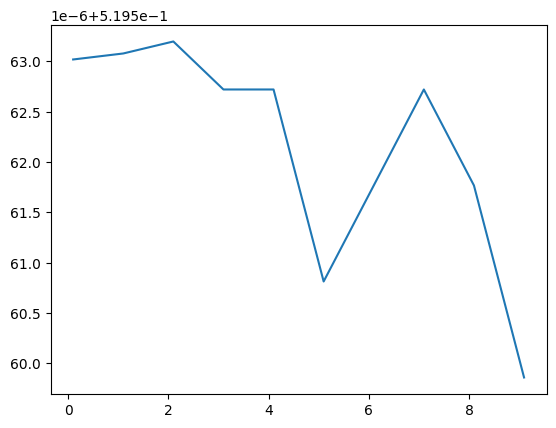

In [48]:
eig_a = []
eig_vecs = []
hessian_a = []
torch.manual_seed(20)
a1 = np.sqrt(x_root)
B_init, A_init = torch.Tensor([[-a1], [a1]]), torch.Tensor([[a1], [a1]])
loratanh = LoRATanh(B_init=B_init, A_init=A_init)
G = torch.Tensor([
    [1, -A_init[0]/A_init[1]],
    [-B_init[0]/B_init[1], B_init[0]*A_init[0]/(B_init[1]*A_init[1])]
])
for a in np.arange(0.1,10.0,1.0):
    Y = loratanh().detach() - a * G / (1 - loratanh().detach()**2)
    print(gradient_norm(Y, loratanh, loss_fn))
    if a <= 0.61:
        return_index = 1
    else:
        return_index = 1
    hessian = get_hessian(loratanh, loss_fn, Y, 4)
    min_eig, eig_vec = get_hessian_eigenvalues(loratanh, loss_fn, Y, 4, return_index=return_index)
    eig_a.append(min_eig)
    eig_vecs.append(eig_vec)
    hessian_a.append(hessian)

plt.plot(np.arange(0.1,10.0,1.0), eig_a)

In [60]:
torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.1300,  0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.1300]], grad_fn=<UnsafeViewBackward0>)

In [49]:
a = 1.0
J = torch.cat([torch.kron(loratanh.A, torch.eye(2)), torch.kron(torch.eye(2), loratanh.B)], axis=-1)
x1 = torch.Tensor([[1],[0]])
x2 = torch.Tensor([[0],[1]])
tanh_derivative = 1 - loratanh()**2
tanh_second_der = -2*loratanh()*tanh_derivative
grad_s = a * G/ tanh_derivative
Delta_Hw = torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0])) + torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

In [50]:
J

tensor([[ 0.8785,  0.0000, -0.8785, -0.0000],
        [ 0.0000,  0.8785,  0.8785,  0.0000],
        [ 0.8785,  0.0000, -0.0000, -0.8785],
        [ 0.0000,  0.8785,  0.0000,  0.8785]], grad_fn=<CatBackward0>)

In [52]:
np.linalg.norm(J.detach().numpy())

2.4846768

In [53]:
torch.norm(loratanh.B)

tensor(1.2423, grad_fn=<LinalgVectorNormBackward0>)

In [83]:
G_outer = torch.zeros(4, 4)
G_outer[:2, 2:] =  a * G
G_outer[2:, :2] =  a * G.T
H_matrix = G_outer + J.T @ Delta_Hw @ J
print(eigs(H_matrix.detach()))

/tmp/ipykernel_2431816/3460051474.py:5: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs(H_matrix.detach()))


(array([-2.3841856e-07+0.j,  2.3841856e-07+0.j, -2.1390458e-15+0.j,
       -8.2264691e-30+0.j], dtype=complex64), array([[-5.00000000e-01,  5.00000060e-01,  7.07106769e-01,
        -2.30483721e-09],
       [-5.00000000e-01,  5.00000000e-01, -7.07106769e-01,
         2.05919779e-08],
       [ 5.00000060e-01,  5.00000000e-01,  1.06499975e-07,
         7.07106769e-01],
       [-5.00000060e-01, -5.00000000e-01,  6.91228763e-08,
         7.07106769e-01]], dtype=float32))


In [84]:
G_eig = eigs(G_outer.detach())[1][:, 0]
print(eigs(G_outer.detach()))

(array([-1.9999999e+00+0.j,  2.0000000e+00+0.j, -1.7943616e-08+0.j,
       -6.9008624e-23+0.j], dtype=complex64), array([[ 5.00000000e-01, -5.00000060e-01,  7.07106769e-01,
        -2.30483721e-09],
       [ 5.00000000e-01, -5.00000000e-01, -7.07106769e-01,
         2.05919832e-08],
       [-5.00000000e-01, -5.00000000e-01,  1.06499975e-07,
         7.07106769e-01],
       [ 5.00000000e-01,  5.00000000e-01,  6.91228763e-08,
         7.07106769e-01]], dtype=float32))


/tmp/ipykernel_2431816/384997480.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  G_eig = eigs(G_outer.detach())[1][:, 0]
/tmp/ipykernel_2431816/384997480.py:2: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs(G_outer.detach()))


In [85]:
print(eigs((J.T @ Delta_Hw @ J).detach()))

(array([-1.9999996e+00+0.j,  2.0000000e+00+0.j, -2.5174865e-08+0.j,
        0.0000000e+00+0.j], dtype=complex64), array([[ 5.0000000e-01, -5.0000006e-01, -7.0710671e-01,  2.6409719e-08],
       [ 4.9999997e-01, -5.0000000e-01,  7.0710677e-01, -3.9583590e-08],
       [ 5.0000000e-01,  5.0000000e-01, -4.4142993e-08,  7.0710677e-01],
       [-5.0000006e-01, -4.9999997e-01, -4.4486544e-08,  7.0710677e-01]],
      dtype=float32))


/tmp/ipykernel_2431816/3178200685.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs((J.T @ Delta_Hw @ J).detach()))


In [76]:
G_eig.T @ (J.T @ Delta_Hw @ J).detach().numpy() @ G_eig

2.0144649

In [67]:
G_eig.T @ (G_outer).detach().numpy() @ G_eig

-0.2

In [43]:
G_eig.T @ (G_outer + J.T @ Delta_Hw @ J).detach().numpy() @ G_eig

0.001446493

In [19]:
loratanh()

tensor(0., grad_fn=<TanhBackward0>)

In [40]:
from torch.optim import SGD

a = 1.0
#B_init, A_init =  torch.Tensor([[1], [-1]]),  torch.Tensor([[1], [-1]])
a1 = np.sqrt(x_root)
B_init, A_init = torch.Tensor([[-a1], [a1]]), torch.Tensor([[a1], [a1]])
model = LoRATanh(B_init=B_init, A_init=A_init)
G = torch.Tensor([
    [1, -A_init[0]/A_init[1]],
    [-B_init[0]/B_init[1], B_init[0]*A_init[0]/(B_init[1]*A_init[1])]
])
Y = model().detach() - a * G / (1 - model().detach()**2)
print(Y)
print("SOSP loss: ", loss_fn(Y, model))
min_eig = np.min(get_hessian_eigenvalues(model, loss_fn, Y, 4)[0])
print("min eig: ", min_eig)

#B_init_opt, A_init_opt = 0.1* torch.randn(2,1), 0.1*torch.randn(2,1)
B_init_opt, A_init_opt = B_init + 0.5* torch.randn(2,1), A_init + 0.5*torch.randn(2,1)
model = LoRATanh(B_init=B_init_opt, A_init=A_init_opt)
optimizer = SGD(model.parameters(), lr=0.1)

for step in range(201):
    loss = loss_fn(Y, model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step%20==0:
        print("step: ", step)
        print("loss: ", loss_fn(Y, model))
        min_eig = np.min(get_hessian_eigenvalues(model, loss_fn, Y, 4)[0])
        print("min eig: ", min_eig)

tensor([[-2.3715,  1.0756],
        [-1.0756,  2.3715]])
SOSP loss:  tensor(5.9412, grad_fn=<MulBackward0>)
[1.0391259e+00 5.1956296e-01 6.7388644e-17 5.1956296e-01]
min eig:  6.7388644e-17
step:  0
loss:  tensor(5.9921, grad_fn=<MulBackward0>)
[ 1.1271957  -0.85462725 -0.07023852  0.37801796]
min eig:  -0.85462725
step:  20
loss:  tensor(5.6919, grad_fn=<MulBackward0>)
[4.832879   1.1135699  0.08506228 0.03219823]
min eig:  0.032198228
step:  40
loss:  tensor(5.4211, grad_fn=<MulBackward0>)
[5.31157    1.6568981  0.07050528 0.17208852]
min eig:  0.07050528
step:  60
loss:  tensor(5.2834, grad_fn=<MulBackward0>)
[5.4140105  2.1115775  0.05103469 0.12487   ]
min eig:  0.051034685
step:  80
loss:  tensor(5.2011, grad_fn=<MulBackward0>)
[5.532181   2.3811815  0.03911924 0.09330085]
min eig:  0.03911924
step:  100
loss:  tensor(5.1447, grad_fn=<MulBackward0>)
[5.6318727  2.5718505  0.03158483 0.07412652]
min eig:  0.03158483
step:  120
loss:  tensor(5.1029, grad_fn=<MulBackward0>)
[5.71473

In [34]:
B_init

tensor([[-0.8785],
        [ 0.8785]])

In [41]:
model.A

Parameter containing:
tensor([[4.2094],
        [0.4910]], requires_grad=True)

In [42]:
model.B

Parameter containing:
tensor([[-0.4318],
        [ 3.7096]], requires_grad=True)

In [9]:
get_hessian_eigenvalues(model, loss_fn, Y, 4)

[-1.3337302   1.3478258  -0.00665256  0.02076071]


(array([[-1.3337302 , -0.00665256,  0.02076071,  1.3478258 ]],
       dtype=float32),
 array([[[-0.61269635, -0.3682118 ,  0.33806783,  0.61215466]],
 
        [[ 0.35361105, -0.6379641 ,  0.5857747 , -0.3533115 ]],
 
        [[ 0.49996045, -0.47807655, -0.5206707 ,  0.5003842 ]],
 
        [[ 0.49960175,  0.47839803,  0.5210376 ,  0.5000532 ]]],
       dtype=float32))

In [11]:
model()

tensor([[-0.8200, -0.8200],
        [ 0.4756,  0.4756]], grad_fn=<TanhBackward0>)

In [12]:
Y

tensor([[-0.8203, -0.8203],
        [ 0.4756,  0.4756]])

In [76]:
B_init_opt, A_init_opt =  0.5* torch.randn(2,1), 0.5*torch.randn(2,1)
model = LoRATanh(B_init=B_init_opt, A_init=A_init_opt)
J = torch.cat([torch.kron(model.A, torch.eye(2)), torch.kron(torch.eye(2), model.B)], axis=-1)


In [77]:
eigs((J.T@J).detach().numpy())

/tmp/ipykernel_270298/341703845.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs((J.T@J).detach().numpy())


(array([0.       +0.j, 1.8419294+0.j, 1.2063087+0.j, 0.6356206+0.j],
       dtype=complex64),
 array([[ 5.8739823e-01, -8.0921292e-01, -1.1731190e-02,  1.8018826e-08],
        [ 6.8913749e-03, -9.4937095e-03,  9.9993122e-01,  1.3841216e-08],
        [-7.8563374e-01, -5.7028234e-01,  9.2061605e-08, -2.3991191e-01],
        [-1.9415319e-01, -1.4093354e-01, -1.8588420e-07,  9.7079468e-01]],
       dtype=float32))

In [78]:
torch.linalg.norm(J.T @ J, ord=2)

tensor(1.8419, grad_fn=<AmaxBackward0>)

In [75]:
torch.norm(model.A)**2 + torch.norm(model.B)**2

tensor(5.1698, grad_fn=<AddBackward0>)

In [62]:
model.A[0] + model.B[1] + torch.sqrt((model.A[0] - model.B[1])**2 + 4*model.A[0]*model.B[1])

tensor([4.7387], grad_fn=<AddBackward0>)

In [64]:
torch.sqrt(
    (torch.norm(model.A)**2 + torch.norm(model.B)**2) / 2 + \
    0.5 * torch.sqrt(
        (torch.norm(model.A)**2 - torch.norm(model.B)**2) ** 2 + 4 * (model.A.T @ model.B) ** 2
    )
)

tensor([[2.1628]], grad_fn=<SqrtBackward0>)

In [65]:
J

tensor([[ 1.4600,  0.0000, -1.4815, -0.0000],
        [ 0.0000,  1.4600,  0.9093,  0.0000],
        [ 0.1281,  0.0000, -0.0000, -1.4815],
        [ 0.0000,  0.1281,  0.0000,  0.9093]], grad_fn=<CatBackward0>)

In [10]:
def xtanhx(x):
    return np.tanh(x) * x

In [17]:
a1_test = 0.5
a2_test= 1.5
b1_test = -0.5
b2_test = 1.5


In [15]:
xtanhx(a1_test * b2_test) + xtanhx(a2_test * b1_test)

0.952723428580931

In [16]:
xtanhx(a1_test * b1_test) + xtanhx(a2_test * b2_test)

2.261788423763258

tensor(2.1722e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 1.1459864e+00  8.9503956e-01 -5.9604637e-09  9.9440798e-02]
tensor(8.6888e-08, grad_fn=<LinalgVectorNormBackward0>)
[-6.8583149e-01 -2.0861625e-08  9.4756907e-01  9.8451066e-01]
tensor(4.2147e-08, grad_fn=<LinalgVectorNormBackward0>)
[-2.3659308e+00 -1.1920928e-08  1.0000987e+00  1.7178624e+00]
tensor(1.8849e-07, grad_fn=<LinalgVectorNormBackward0>)
[-4.0668592e+00  8.9406967e-08  1.0526283e+00  2.4720428e+00]
tensor(8.4294e-08, grad_fn=<LinalgVectorNormBackward0>)
[-5.7716055e+00  2.3841856e-08  1.1051579e+00  3.2300413e+00]
tensor(3.4755e-07, grad_fn=<LinalgVectorNormBackward0>)
[-7.4777112e+00  5.9604652e-08  1.1576869e+00  3.9893992e+00]
tensor(1.6859e-07, grad_fn=<LinalgVectorNormBackward0>)
[-9.1844530e+00  1.2102169e+00  5.9604645e-08  4.7493935e+00]
tensor(3.7697e-07, grad_fn=<LinalgVectorNormBackward0>)
[-1.0891546e+01  1.2627465e+00 -1.3113022e-07  5.5097384e+00]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[-1.2598

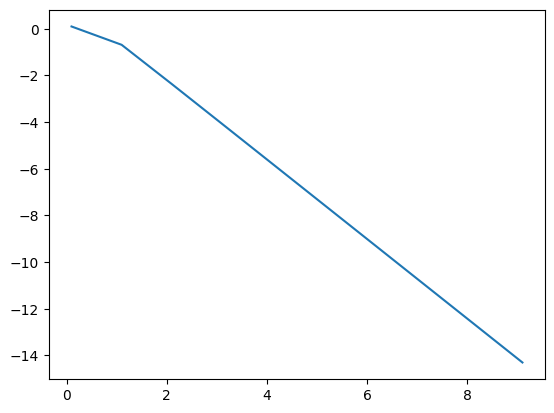

In [20]:
eig_a = []
eig_vecs = []
hessian_a = []
torch.manual_seed(20)
#a1 = np.sqrt(x_root)
#B_init, A_init = torch.Tensor([[-a1], [a1]]), torch.Tensor([[a1], [a1]])
B_init, A_init = torch.Tensor([[b1_test], [b2_test]]), torch.Tensor([[a1_test], [a2_test]])
loratanh = LoRATanh(B_init=B_init, A_init=A_init)
G = torch.Tensor([
    [1, -A_init[0]/A_init[1]],
    [-B_init[0]/B_init[1], B_init[0]*A_init[0]/(B_init[1]*A_init[1])]
])
for a in np.arange(0.1,10.0,1.0):
    Y = loratanh().detach() - a * G / (1 - loratanh().detach()**2)
    print(gradient_norm(Y, loratanh, loss_fn))
    if a <= 0.61:
        return_index = 1
    else:
        return_index = 0
    hessian = get_hessian(loratanh, loss_fn, Y, 4)
    min_eig, eig_vec = get_hessian_eigenvalues(loratanh, loss_fn, Y, 4, return_index=return_index)
    eig_a.append(min_eig)
    eig_vecs.append(eig_vec)
    hessian_a.append(hessian)

plt.plot(np.arange(0.1,10.0,1.0), eig_a)

In [21]:
a = 1.0
J = torch.cat([torch.kron(loratanh.A, torch.eye(2)), torch.kron(torch.eye(2), loratanh.B)], axis=-1)
x1 = torch.Tensor([[1],[0]])
x2 = torch.Tensor([[0],[1]])
tanh_derivative = 1 - loratanh()**2
tanh_second_der = -2*loratanh()*tanh_derivative
grad_s = a * G/ tanh_derivative
Delta_Hw = torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0])) + torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

In [22]:
G_outer = torch.zeros(4, 4)
G_outer[:2, 2:] =  a * G
G_outer[2:, :2] =  a * G.T
H_matrix = G_outer + J.T @ Delta_Hw @ J
print(eigs(H_matrix.detach()))

/tmp/ipykernel_1616296/3460051474.py:5: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs(H_matrix.detach()))


(array([-1.7079053e+00+0.j,  5.2529491e-02+0.j,  2.2480329e-08+0.j,
        7.6115739e-01+0.j], dtype=complex64), array([[ 0.7070924 , -0.67082024, -0.22360651, -0.00451326],
       [ 0.00451325, -0.22360744,  0.67082053,  0.7070924 ],
       [-0.70709234, -0.6708201 , -0.22360647,  0.00451315],
       [ 0.00451321,  0.2236075 , -0.6708205 ,  0.70709234]],
      dtype=float32))


In [25]:
G_eig = eigs(G_outer.detach())[1][:, 1]
print(eigs(G_outer.detach()))

(array([ 1.1111110e+00+0.j, -1.1111112e+00+0.j,  1.7888599e-08+0.j,
       -3.2030139e-09+0.j], dtype=complex64), array([[ 0.6708203 ,  0.6708204 , -0.26102683,  0.05009668],
       [ 0.22360681,  0.22360685,  0.78308034, -0.15029006],
       [ 0.6708204 , -0.6708203 ,  0.1785077 ,  0.31223437],
       [-0.22360681,  0.22360677,  0.5355233 ,  0.9367032 ]],
      dtype=float32))


/tmp/ipykernel_1616296/124209584.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  G_eig = eigs(G_outer.detach())[1][:, 1]
/tmp/ipykernel_1616296/124209584.py:2: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  print(eigs(G_outer.detach()))


In [24]:
eigs((J.T @ Delta_Hw @ J).detach())

/tmp/ipykernel_1616296/778550646.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigs((J.T @ Delta_Hw @ J).detach())


(array([ 9.3361133e-01+0.j,  9.8661985e-08+0.j, -1.0585818e+00+0.j,
        -7.6924783e-01+0.j], dtype=complex64),
 array([[-0.13431743, -0.2236067 , -0.67082053, -0.6942324 ],
        [-0.69423264,  0.67082053, -0.22360699,  0.13431735],
        [ 0.13431735, -0.22360677, -0.6708201 ,  0.69423276],
        [-0.69423246, -0.6708203 ,  0.22360682,  0.13431722]],
       dtype=float32))

In [28]:
G_eig @ ((G_outer + J.T @ Delta_Hw @ J).detach().numpy()) @ G_eig

-1.4703739

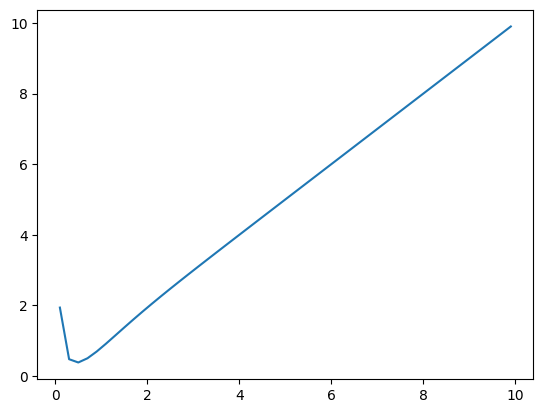

In [31]:
f_x = np.arange(0.1, 10, 0.2)
c = 0.2
f_y = xtanhx(f_x) + xtanhx(c / f_x)
plt.plot(f_x, f_y)

In [8]:
a1_test = np.sqrt(x_root) - 0.001
a2_test= np.sqrt(x_root) + 0.001
b1_test = -(np.sqrt(x_root) - 0.001)
b2_test = np.sqrt(x_root) + 0.001

In [11]:
print(xtanhx(a1_test * b2_test) + xtanhx(a2_test * b1_test))

0.9999978086814664


In [12]:
xtanhx(a1_test * b1_test) + xtanhx(a2_test * b2_test)

1.0000039822960953

tensor(4.4703e-08, grad_fn=<LinalgVectorNormBackward0>)
[ 1.0391262e+00 -1.7611821e-08  5.1955825e-01  5.1956534e-01]
tensor(1.8849e-07, grad_fn=<LinalgVectorNormBackward0>)
[-1.0691134e-07  1.0392047e+00  5.1956964e-01  5.1946473e-01]
tensor(3.7697e-07, grad_fn=<LinalgVectorNormBackward0>)
[-1.3643714e-07  1.0395100e+00  5.1957357e-01  5.1914459e-01]
tensor(3.3717e-07, grad_fn=<LinalgVectorNormBackward0>)
[1.6104907e-07 1.0400417e+00 5.1957828e-01 5.1859826e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[-7.6820577e-08  1.0407977e+00  5.1958281e-01  5.1782656e-01]
tensor(6.7435e-07, grad_fn=<LinalgVectorNormBackward0>)
[1.0417773e+00 2.7972681e-07 5.1958722e-01 5.1683366e-01]
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
[1.0429770e+00 2.7973300e-07 5.1959199e-01 5.1561964e-01]
tensor(6.7435e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 1.0443910e+00 -1.9655801e-07  5.1959389e-01  5.1418793e-01]
tensor(6.7435e-07, grad_fn=<LinalgVectorNormBackward0>)
[ 1.0460237e+00 -1.9709303e-

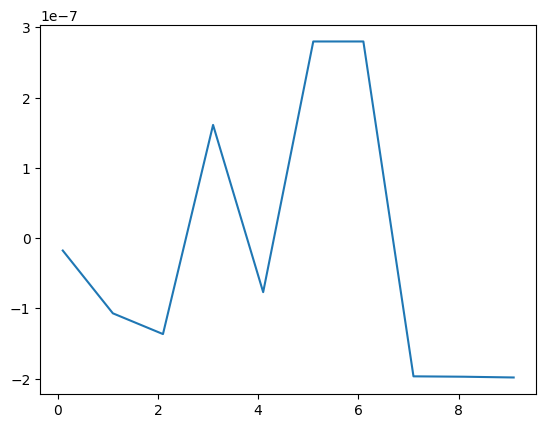

In [16]:
eig_a = []
eig_vecs = []
hessian_a = []
torch.manual_seed(20)
#a1 = np.sqrt(x_root)
#B_init, A_init = torch.Tensor([[-a1], [a1]]), torch.Tensor([[a1], [a1]])
B_init, A_init = torch.Tensor([[b1_test], [b2_test]]), torch.Tensor([[a1_test], [a2_test]])
loratanh = LoRATanh(B_init=B_init, A_init=A_init)
G = torch.Tensor([
    [1, -A_init[0]/A_init[1]],
    [-B_init[0]/B_init[1], B_init[0]*A_init[0]/(B_init[1]*A_init[1])]
])
for a in np.arange(0.1,10.0,1.0):
    Y = loratanh().detach() - a * G / (1 - loratanh().detach()**2)
    print(gradient_norm(Y, loratanh, loss_fn))
    if a <= 0.61:
        return_index = 0
    else:
        return_index = 0
    hessian = get_hessian(loratanh, loss_fn, Y, 4)
    min_eig, eig_vec = get_hessian_eigenvalues(loratanh, loss_fn, Y, 4, return_index=return_index)
    eig_a.append(min_eig)
    eig_vecs.append(eig_vec)
    hessian_a.append(hessian)

plt.plot(np.arange(0.1,10.0,1.0), eig_a)

In [17]:
a = 1.0
J = torch.cat([torch.kron(loratanh.A, torch.eye(2)), torch.kron(torch.eye(2), loratanh.B)], axis=-1)
x1 = torch.Tensor([[1],[0]])
x2 = torch.Tensor([[0],[1]])
tanh_derivative = 1 - loratanh()**2
tanh_second_der = -2*loratanh()*tanh_derivative
grad_s = a * G/ tanh_derivative
Delta_Hw = torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0])) + torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

In [ ]:
u = 
x = 1/(2**0.5) * np.concatenate([-u, v])

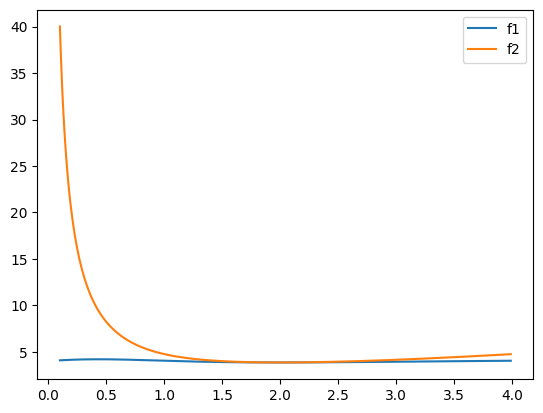

In [2]:
def f1(x, R):
    return x * np.tanh(R/x) + R/x * np.tanh(x)

def f2(x, R):
    return x * np.tanh(x) + R/x * np.tanh(R/x)

x = np.arange(0.1, 4, 0.01)
R = 4
plt.plot(x, f1(x, R))
plt.plot(x, f2(x, R))
plt.legend(["f1", "f2"])

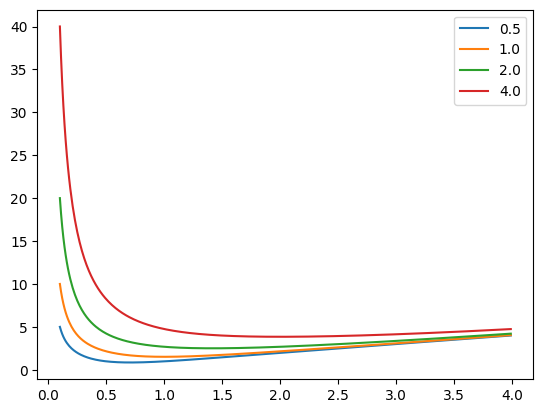

In [5]:
for R in [0.5, 1.0, 2.0, 4.0]:
    plt.plot(x, f2(x, R))
plt.legend([0.5, 1.0, 2.0, 4.0])

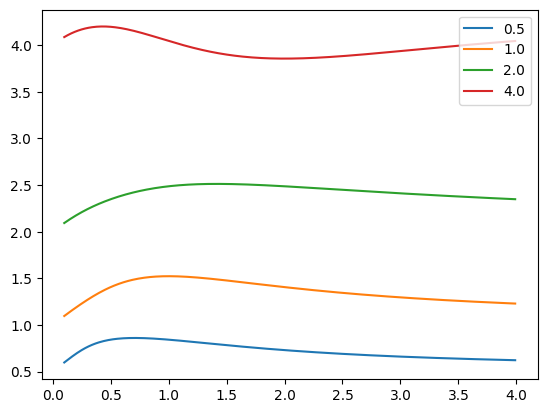

In [4]:
for R in [0.5, 1.0, 2.0, 4.0]:
    plt.plot(x, f1(x, R))
plt.legend([0.5, 1.0, 2.0, 4.0])

In [13]:
def f1_prime(x, R):
    Rx = R / x
    return np.tanh(Rx) + Rx*np.tanh(Rx)**2-Rx/x*np.tanh(x)-Rx*np.tanh(x)**2


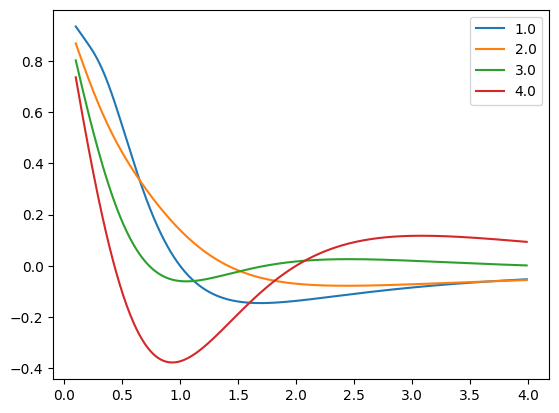

In [10]:
for R in [1.0, 2.0, 3.0, 4.0]:
    plt.plot(x, f1_prime(x, R))
plt.legend([1.0, 2.0, 3.0, 4.0])

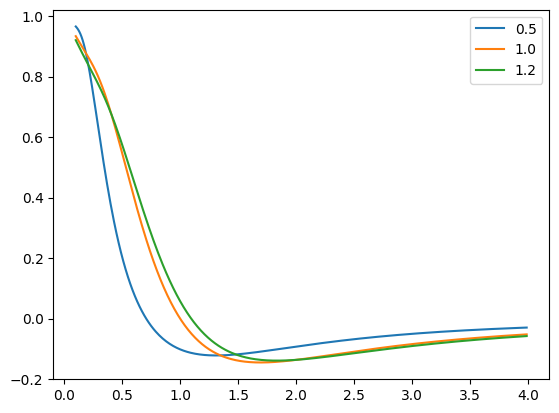

In [24]:
def f1_prime_2(x, R):
    Rx = R / x
    #return -Rx/x*np.tanh(x)-Rx*np.tanh(x)**2
    return np.tanh(Rx) + Rx*np.tanh(Rx)**2-Rx/x*np.tanh(x)-Rx*np.tanh(x)**2

for R in [0.5, 1.0, 1.2]:
    plt.plot(x, f1_prime_2(x, R))
plt.legend([0.5, 1.0, 1.2])

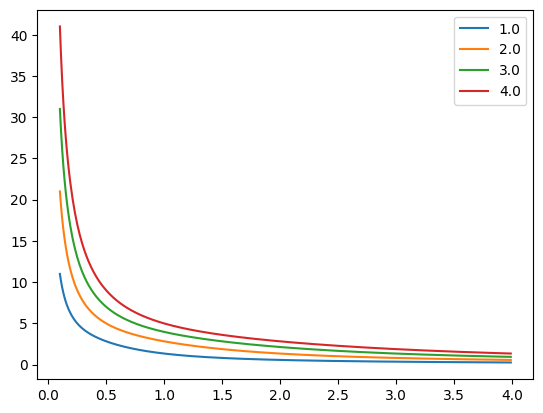

In [18]:
def f1_prime_3(x, R):
    Rx = R / x
    return np.tanh(Rx)+Rx*np.tanh(Rx)**2

for R in [1.0, 2.0, 3.0, 4.0]:
    plt.plot(x, f1_prime_3(x, R))
plt.legend([1.0, 2.0, 3.0, 4.0])

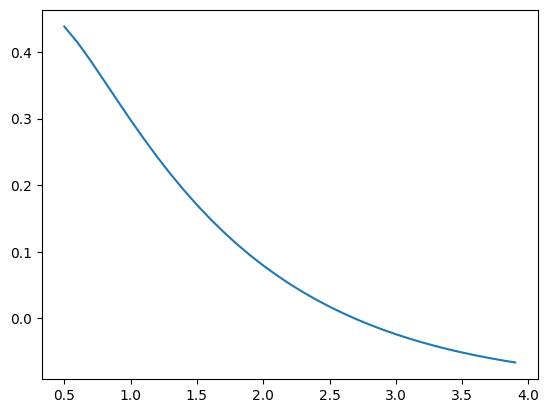

In [2]:
def r_prime(R):
    return np.tanh(R**0.5)*(2/np.cosh(R**0.5)**2-1/R) + 1/(R**0.5)/np.cosh(R**0.5)**2

R_range =  np.arange(0.5, 4.0, 0.1)
plt.plot(R_range, r_prime(R_range))

In [30]:
r_prime(2.6863)

9.664589198793427e-07

In [12]:
np.tanh(4/1.0) - 4*np.tanh(1)

-2.0470473240839926

In [24]:
f2(x, R).min()

3.8561103203032676

In [25]:
f1(x, R).max()

4.045705923562126

In [3]:
def b_prime(x):
    return x * np.tanh(x) + x**2 / np.cosh(x)**2

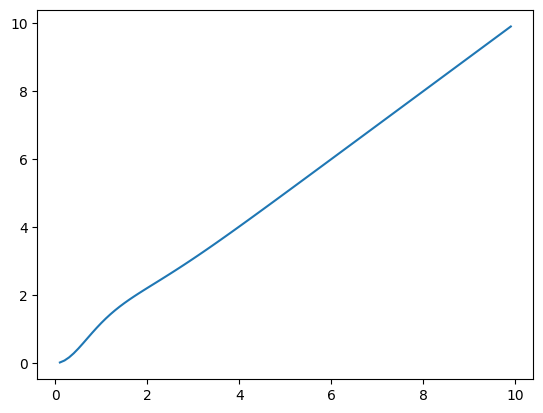

In [5]:
R_range =  np.arange(0.1, 10.0, 0.1)
plt.plot(R_range, b_prime(R_range))

In [7]:
a = 1.0
m, n = 3, 3
A = torch.Tensor([[1], [-1], [-1]])
B = torch.Tensor([[1], [-1], [-1]])
tanh_ba = torch.tanh(B @ A.T)
J = torch.cat([torch.kron(A, torch.eye(m)), torch.kron(torch.eye(n), B)], axis=-1)
#x1 = torch.Tensor([[1],[0]])
#x2 = torch.Tensor([[0],[1]])
x = torch.eye(n)
#tanh_derivative = 1 - loratanh()**2
#tanh_second_der = -2*loratanh()*tanh_derivative
G = torch.Tensor(
    [[2, 1, 1],
     [1, 2, -1],
     [1, -1, 2]]
)
grad_s = a * G #/ tanh_derivative

Delta_Hw = 0
for i in range(3):
    Delta_Hw += torch.kron(torch.outer(x[i], x[i]), torch.diag(grad_s[:,i] * tanh_ba[:,i]))
#Delta_Hw = torch.kron(x1 @ x1.T, torch.diag(grad_s[:,0] * tanh_second_der[:,0])) + torch.kron(x2 @ x2.T, torch.diag(grad_s[:,1] * tanh_second_der[:,1]))

In [12]:
Delta_Hw

tensor([[ 1.5232,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000, -0.7616,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000, -0.7616,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.7616,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.5232,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7616,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7616,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7616,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.5232]])

In [10]:
eigvals, eigvecs = eigs(J.T @ Delta_Hw @ J)
print(eigvals)
print(eigvecs)

[-2.2847826e+00+0.j  2.2847824e+00+0.j -3.6353512e-08+0.j
  2.2847826e+00+0.j -2.2847831e+00+0.j -1.2722961e-07+0.j]
[[ 5.7735038e-01 -5.7735020e-01  5.7735008e-01 -9.3821943e-02
  -2.2894224e-02 -4.4729292e-01]
 [ 2.8867510e-01 -2.8867507e-01 -5.7735038e-01  4.4644284e-01
   4.8815960e-01  4.4729319e-01]
 [ 2.8867510e-01 -2.8867507e-01 -5.7735038e-01 -5.4026479e-01
  -5.1105380e-01  4.4729313e-01]
 [-5.7735026e-01 -5.7735032e-01  2.5104960e-08 -9.3821935e-02
   2.2894245e-02 -3.6505100e-01]
 [-2.8867513e-01 -2.8867516e-01  1.2552480e-08  4.4644299e-01
  -4.8815972e-01  3.6505100e-01]
 [-2.8867513e-01 -2.8867516e-01  1.2552480e-08 -5.4026490e-01
   5.1105386e-01  3.6505106e-01]]


/tmp/ipykernel_3837670/2976666906.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigvals, eigvecs = eigs(J.T @ Delta_Hw @ J)


In [14]:
J @ eigvecs[:, 0]

tensor([ 1.1921e-07,  8.6603e-01,  8.6603e-01, -8.6603e-01,  2.9802e-08,
         2.9802e-08, -8.6603e-01,  2.9802e-08,  2.9802e-08])

In [13]:
J @ eigvecs[:, 1]

tensor([-1.1547,  0.2887,  0.2887,  0.2887,  0.5774,  0.5774,  0.2887,  0.5774,
         0.5774])

In [15]:
J @ eigvecs[:, 3]

tensor([-0.1876,  0.5403, -0.4464,  0.5403, -0.8929,  0.0938, -0.4464,  0.0938,
         1.0805])

In [6]:
torch.outer(x[i], x[i])

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.]])